# Упражнение 3.2

In [ ]:
import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

--2024-05-23 18:48:09--  https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py [following]
--2024-05-23 18:48:09--  https://raw.githubusercontent.com/AllenDowney/ThinkDSP/master/code/thinkdsp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48574 (47K) [text/plain]
Saving to: ‘thinkdsp.py’

thinkdsp.py         100%[===================>]  47.44K  --.-KB/s    in 0.02s   

2024-05-23 18:48:09 (2.59 MB/s) - ‘thinkdsp.py’ saved [48574/48574]



Давайте создадим класс SawtoothChirp, который наследует функциональность класса Chirp и изменяет метод evaluate для генерации пилообразного сигнала с линейно увеличивающейся или уменьшающейся частотой.

In [ ]:
from thinkdsp import Chirp
from thinkdsp import normalize, unbias
import numpy as np

PI2 = 2 * np.pi

class SawtoothChirp(Chirp):
    """Represents a sawtooth signal with varying frequency."""

    def evaluate(self, ts):
        """Helper function that evaluates the signal.

        ts: float array of times
        """
        freqs = np.linspace(self.start, self.end, len(ts))
        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        cycles = phases / PI2
        frac, _ = np.modf(cycles)
        ys =  normalize(unbias(frac), self.amp)
        return ys

Давайте получим спектрограмму данного сигнала и прослушаем его запись.

In [ ]:
signal = SawtoothChirp(start=220, end=880)
wave = signal.make_wave(duration=2, framerate=4000)
wave.apodize()
wave.make_audio()

Также изобразим график спектрограммы.

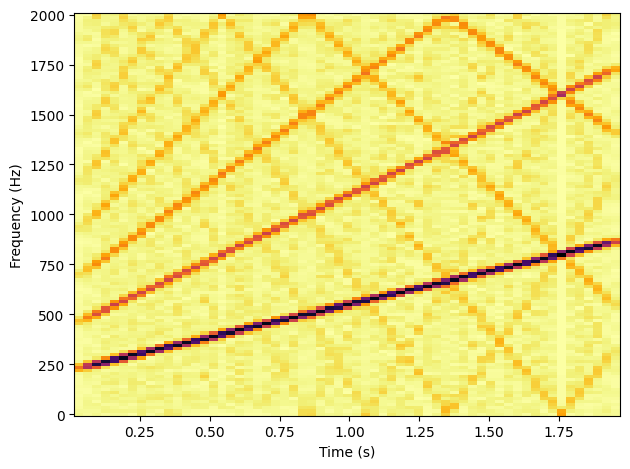

In [ ]:
from thinkdsp import decorate
sp = wave.make_spectrogram(256)
sp.plot()
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Эффект биения явно заметен, и его также можно услышать в аудиозаписи.

# Упражнение 3.3

Давайте создадим пилообразный чирп, который изменяется в диапазоне от 2500 до 3000 Гц, а затем сгенерируем сигнал продолжительностью 1 секунду и с частотой дискретизации 20 кГц на основе этого чирпа.

In [ ]:
signal = SawtoothChirp(start=2500, end=3000)
wave = signal.make_wave(duration=1, framerate=20000)
wave.make_audio()

Распечатаем спектр сигнала.

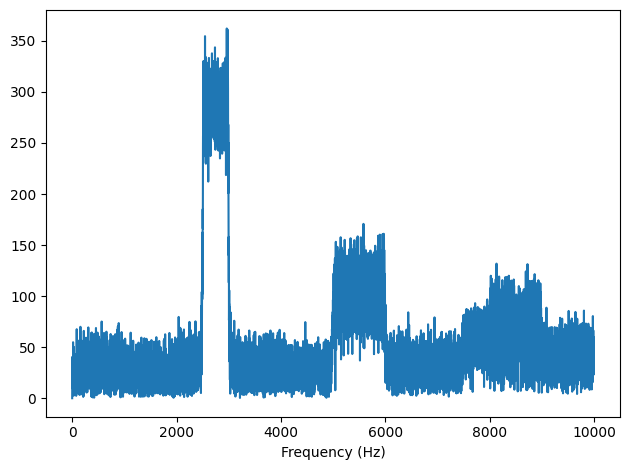

In [ ]:
wave.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

Базовая частота колеблется от 2500 до 3000Hz.

# Упражнение 3.4

В музыкальном контексте глиссандо представляет собой игру ноты, которая плавно переходит от одной высоты к другой, что схоже с чирпом. Давайте послушаем начало композиции "Rhapsody in Blue" Джорджа Гершвина и выведем на печать её спектрограмму.

In [ ]:
from thinkdsp import read_wave
wave = read_wave('rhapblue11924.wav')
wave = wave.segment(start = 1, duration= 6)
wave.make_audio()

Далее распечатаем спектрограмму.

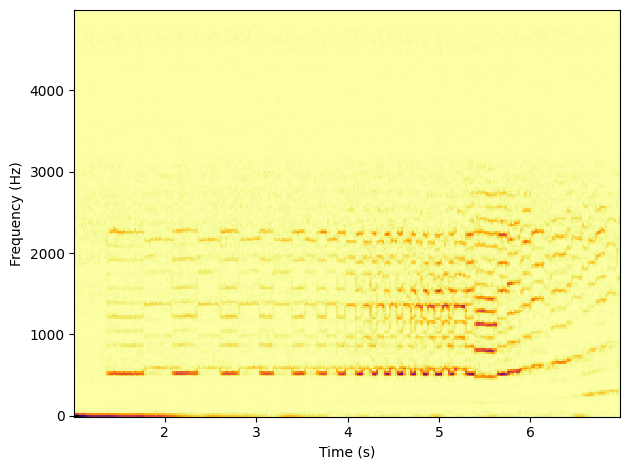

In [ ]:
wave.make_spectrogram(512).plot(high=5000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

# Упражнение 3.5

Тромбонист может производить глиссандо, продувая мундштук и перемещая кулису тромбона. Это приводит к изменению общей длины инструмента, а высота звучащей ноты обратно пропорциональна этой длине. Если предположить, что музыкант двигает кулису с постоянной скоростью, как изменится частота во времени?

Давайте напишем класс TromboneGliss, который расширяет функциональность класса Chirp и предоставляет метод evaluate.

In [ ]:
class TromboneGliss(Chirp):
    """Represents a trombone-like signal with varying frequency."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times

        returns: float wave array
        """
        l1, l2 = 1.0 / self.start, 1.0 / self.end
        lengths = np.linspace(l1, l2, len(ts))
        freqs = 1 / lengths

        dts = np.diff(ts, prepend=0)
        dphis = PI2 * freqs * dts
        phases = np.cumsum(dphis)
        ys = self.amp * np.cos(phases)
        return ys

Давайте создадим сигнал, который эмулирует глиссандо на тромбоне от ноты C3 до ноты F3 и обратно до ноты C3. Частота ноты C3 составляет 262 Гц, а ноты F3 - 349 Гц.

In [ ]:
low = 262
high = 349

signal = TromboneGliss(low, high)
wave1 = signal.make_wave(duration=1)
wave1.apodize()
wave1.make_audio()

signal = TromboneGliss(high, low)
wave2 = signal.make_wave(duration=1)
wave2.apodize()
wave2.make_audio()

wave = wave1 | wave2
wave.make_audio()

Далее распечатаем спектрограмму.

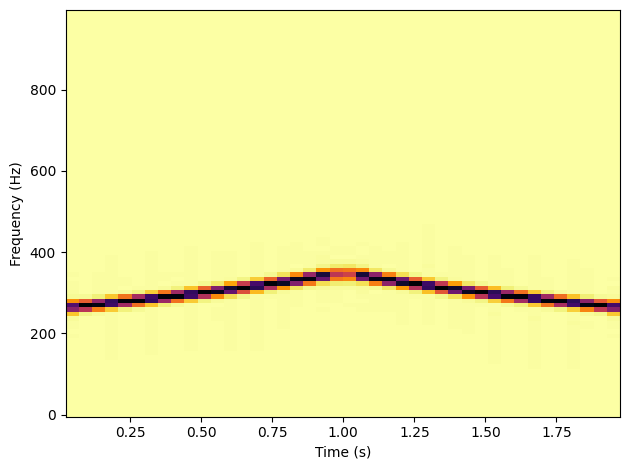

In [ ]:
sp = wave.make_spectrogram(1024)
sp.plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

График и звуковое воспроизведение демонстрируют, что частота сначала увеличивается, а затем уменьшается до исходного значения, что свидетельствует о правильной работе созданного класса. Однако из-за небольшой разницы между начальной и конечной частотами нельзя однозначно определить, похоже ли глиссандо на тромбоне на линейное или экспоненциальное глиссандо.

# Упражнение 3.6

Давайте послушаем аудиозапись последовательности гласных звуков.

In [ ]:
from thinkdsp import read_wave
wave = read_wave('vowel_sounds.wav')
wave.make_audio()

Давайте рассмотрим спектрограмму последовательности гласных звуков.

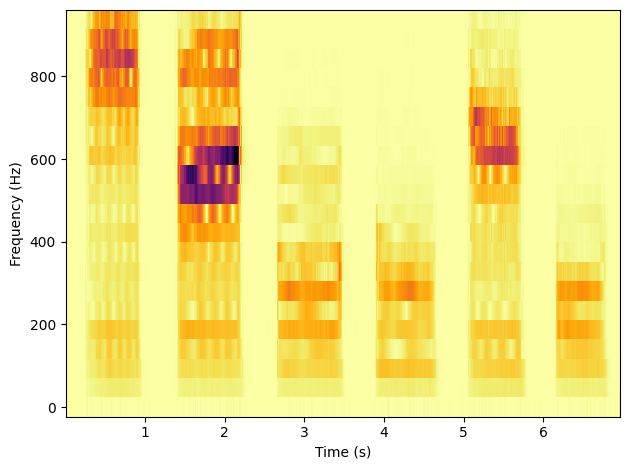

In [ ]:
wave.make_spectrogram(1024).plot(high=1000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

Спектрограмма показывает, что произношение звуков в записи очень похоже, и их сложно различить отдельно друг от друга. Это указывает на то, что звуки сливаются вместе, и различить их на основе только этой записи довольно сложно. Для более точного анализа может потребоваться использование дополнительных данных или методов обработки сигнала. Тем не менее, буква "И" выделяется более низкой частотой по сравнению с другими звуками.